# Tools - Edge Seal Oxygen Ingress Calculator tool

### Calculation of oxygen ingress profile through an edge seal and into the encapsulant.

**Requirements:**
- Local weather data file or site longitude and latittude.
- Properties and dimensions of the edge seal.

**Objectives:**
1. Import weather data.
2. Set up the calculations.
3. Calculate oxygen ingress into an edge seal.
3. Incorporate an oxygen consumption model.
4. Plot the data.

**Background:**

This performs a 1-D finite difference model for oxygen ingress through an edge seal and into an encapsulant. This is effectively an infinitely long module with a prescribed width.The output is then displayed graphically.

In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.3.3

In [2]:
import os
from pathlib import Path
import pvdeg
import pandas as pd
from pvdeg import DATA_DIR
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

## 1. Import Weather Data

The function has these minimum requirements when using a weather data file:
- Weather data containing (at least) DNI, DHI, GHI, Temperature, RH, and Wind-Speed data at module level.
- Site meta-data containing (at least) latitude, longitude, and time zone

Alternatively one may can get meterological data from the NSRDB or PVGIS with just the longitude and latitude. This function for the NSRDB (via NSRDB 'PSM3') works primarily for most of North America and South America. PVGIS works for most of the rest of the world (via SARAH 'PVGIS'). See the tutorial "Weather Database Access.ipynb" tutorial on PVdeg or Jensen et al. https://doi.org/10.1016/j.solener.2023.112092 for satellite coverage information.

In [3]:
# Get data from a supplied data file (Do not use the next box of code if using your own file)
weather_file = os.path.join(DATA_DIR, 'psm3_demo.csv')
weather_df, meta = pvdeg.weather.read(weather_file,'csv')
print(meta)

{'Source': 'NSRDB', 'Location ID': 145809.0, 'City': '-', 'State': '-', 'Country': '-', 'Clearsky DHI Units': 'w/m2', 'Clearsky DNI Units': 'w/m2', 'Clearsky GHI Units': 'w/m2', 'Dew Point Units': 'c', 'DHI Units': 'w/m2', 'DNI Units': 'w/m2', 'GHI Units': 'w/m2', 'Solar Zenith Angle Units': 'Degree', 'Temperature Units': 'c', 'Pressure Units': 'mbar', 'Relative Humidity Units': '%', 'Precipitable Water Units': 'cm', 'Wind Direction Units': 'Degrees', 'Wind Speed Units': 'm/s', 'Cloud Type -15': 'N/A', 'Cloud Type 0': 'Clear', 'Cloud Type 1': 'Probably Clear', 'Cloud Type 2': 'Fog', 'Cloud Type 3': 'Water', 'Cloud Type 4': 'Super-Cooled Water', 'Cloud Type 5': 'Mixed', 'Cloud Type 6': 'Opaque Ice', 'Cloud Type 7': 'Cirrus', 'Cloud Type 8': 'Overlapping', 'Cloud Type 9': 'Overshooting', 'Cloud Type 10': 'Unknown', 'Cloud Type 11': 'Dust', 'Cloud Type 12': 'Smoke', 'Fill Flag 0': 'N/A', 'Fill Flag 1': 'Missing Image', 'Fill Flag 2': 'Low Irradiance', 'Fill Flag 3': 'Exceeds Clearsky', 'F

In [4]:
# This routine will get a meteorological dataset from anywhere in the world where it is available 
#weather_id = (24.7136, 46.6753) #Riyadh, Saudi Arabia
#weather_id = (35.6754, 139.65) #Tokyo, Japan
#weather_id = (-43.52646, 172.62165) #Christchurch, New Zealand
#weather_id = (64.84031, -147.73836) #Fairbanks, Alaska
#weather_id = (65.14037, -21.91633) #Reykjavik, Iceland
weather_id = (33.4152, -111.8315) #Mesa, Arizona
weather_df, meta = pvdeg.weather.get_anywhere(id=weather_id)
print(meta)

{'latitude': 33.4152, 'longitude': -111.8315, 'altitude': 381.0, 'wind_height': 10, 'Source': 'PVGIS'}


In [5]:
#This computes a module temperature. Here the default is an open rack system, but other options include: 
#       'open_rack_glass_glass', 
#       'close_mount_glass_glass',
#       'insulated_back_glass_polymer'

temperature = pvdeg.temperature.temperature(
    weather_df=weather_df,
    meta=meta,
    cell_or_mod="module", 
    temp_model="sapm",
    conf="open_rack_glass_polymer",
)

temperature = pd.DataFrame(temperature, columns = ['module_temperature'])
temperature['time'] = list(range(8760))

The array tilt angle was not provided, therefore the latitude tilt of 33.4 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.


## 2. Set up the Calculations

There is a library of some materials and the relevant oxygen ingress parameters that can be used.

In [6]:
es = 'OX005'    #This is the number for the edge seal in the json file
enc = 'OX003'   #This is the number for the encapsulant in the json file
esw = 1.5   #This is the edge seal width in [cm]
encw = 10   #This is the encapsulant width in [cm]
sn = 20     #This is the number of edge seal nodes to use
en = 50     #This is the number of encapsulant nodes to use
pressure = 0.2109 * (1 - 0.0065 * meta.get('altitude') / 288.15) ** 5.25588

## 3. Run the Calculations

This runs the calculations for diffusion using a simple 1-D finite difference calculation. The first set of calculations is just for diffusion, then the next two include some consumption of oxygen. In typical PV applications, it is common for oxygen ingress distance to be limited by its consumption rate in the encapsulant.

In [7]:
oxygen_profile = pvdeg.diffusion.esdiffusion(
    temperature=temperature, 
    edge_seal=es, 
    encapsulant=enc, 
    edge_seal_width=esw, 
    encapsulant_width=encw, 
    seal_nodes=sn, 
    encapsulant_nodes=en, 
    press=pressure, 
    repeat=2
)

The edge seal is Helioseal_101_dry .
The encapsulant is EVA .


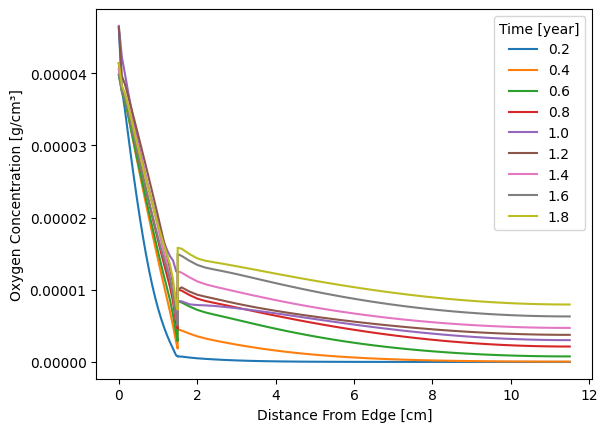

In [8]:
n_lines=10
for index in range(1,n_lines):
    plt.plot(oxygen_profile.iloc[int(np.trunc(index*(len(oxygen_profile)-1)/n_lines))], label=np.round(index*((len(oxygen_profile)-1)/n_lines)/8760,3))
plt.legend(title='Time [year]')
plt.ylabel('Oxygen Concentration [g/cm³]')
plt.xlabel('Distance From Edge [cm]')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

In [9]:
print(oxygen_profile)

         0.000000      0.076923      0.153846      0.230769      0.307692   \
0.0       0.000048  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1.0       0.000048  4.025938e-07  0.000000e+00  0.000000e+00  0.000000e+00   
2.0       0.000048  7.914468e-07  3.295784e-09  0.000000e+00  0.000000e+00   
3.0       0.000048  1.165328e-06  9.571569e-09  2.635343e-11  0.000000e+00   
4.0       0.000049  1.525385e-06  1.852325e-08  1.006938e-10  2.058149e-13   
...            ...           ...           ...           ...           ...   
17514.0   0.000042  4.267309e-05  4.035455e-05  3.816304e-05  3.614315e-05   
17515.0   0.000043  4.255340e-05  4.035980e-05  3.817013e-05  3.614761e-05   
17516.0   0.000043  4.247354e-05  4.035994e-05  3.817617e-05  3.615158e-05   
17517.0   0.000045  4.244049e-05  4.035799e-05  3.818062e-05  3.615468e-05   
17518.0   0.000047  4.244476e-05  4.035617e-05  3.818351e-05  3.615683e-05   

         0.384615   0.461538   0.538462   0.615385   0.692308  